# Text generation with an RNN

In this notebook we will learn how to generate text with a Recurrent Neural Network.

We will work with a dataset of Shakespeare's writing from Andrej Karpathy's article [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). 

Given a sequence of characters from this data (for example "Shakespear"), we will train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

### Import the necessary modules

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch Version:  1.8.1+cu111
Using device: cuda:0


### Download the Shakespeare dataset

In [2]:
! wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

--2021-05-14 02:01:26--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.184.16, 142.250.200.144, 142.250.200.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.184.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt.2’

shakespeare.txt.2   100%[===================>]   1.06M   961KB/s    in 1.1s    

2021-05-14 02:01:28 (961 KB/s) - ‘shakespeare.txt.2’ saved [1115394/1115394]



###  Create a dataset class

For training we need a dataset of (input, label) pairs. Where input and label are sequences of characters. At each time step the input is the current character and the label is the next character. For example:

```
input = ['S', 'h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r']
label = ['h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r', 'e']
 ```

Actually we will vectorize the characters to convert them into numerical values. 

```
input = [44, 7, 0, 10, 4, 18, 15, 4, 0, 17]
label = [7, 0, 10, 4, 18, 15, 4, 0, 17, 4]
```

where each integer value is a class label, and the number of classes is the number of unique characters in our training data (our vocabulary size).

In [3]:
class ShakespeareDataset():
    def __init__(self, sequence_length,):
        self.sequence_length = sequence_length
        # The whole sequence of characters in the text file (including chracters like the end of line character '\n', punctuation marks, etc.)
        self.chars = self.load_chars()
        # The list of unique characters (our vocabulary)
        self.uniq_chars = self.get_uniq_chars()

        # A dictionary with indexes as keys and characters as values
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        # A dictionary with characters as keys and indexes as values
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        # The whole sequence of character indexes
        # We want to vectorize our text using one-hot vectors at character level
        # But instead of using the one-hot vector we just keep the index of the 1 value
        self.chars_indexes = [self.char_to_index[w] for w in self.chars]

        # Split the sequence into chunks of `sequence_length` characters
        # `x` is the input to the model and `y` is the output of the model
        # `y` is the same seuqence as `x` but one character shifted to the right.
        self.x, self.y = self.get_data()

    def load_chars(self):
        with open('shakespeare.txt') as fp:
          text = fp.read()
        print(f'Length of text: {len(text)} characters')
        return text

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indexes)-self.sequence_length,self.sequence_length):
            x.append(np.array(self.chars_indexes[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indexes[index+1:index+self.sequence_length+1]))
        
        return  np.array(x), np.array(y)

Now we can use the [`torch.utils.data.TensorDataset`](https://pytorch.org/docs/stable/data.html) and [`torch.utils.data.Dataloader`](https://pytorch.org/docs/stable/data.html) classes to create the PyTorch dataloader. Notice that the `TensorDataset` class allows us to easily create a PyTorch `Dataset` from numpy arrays `(inputs, labels)`.

In [4]:
# Create the dataset
sequence_length = 100
dataset = ShakespeareDataset(sequence_length)

print(f'We have {dataset.x.shape[0]} input sequence samples of length {dataset.x.shape[1]} \
and {dataset.y.shape[0]} label sequences of length {dataset.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_data = TensorDataset(torch.from_numpy(dataset.x), torch.from_numpy(dataset.y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

Length of text: 1115394 characters
Unique characters (vocabulary size): 65
We have 11153 input sequence samples of length 100 and 11153 label sequences of length 100


## Build the model

Our model has three layers:

* `torch.nn.Embedding`: The input layer. A trainable lookup table that will map each character-ID (class ID) to a dense vector with `embedding_dim` dimensions;
* `torch.nn.GRU`: A type of RNN with `hidden_dim` units
* `torch.nn.Linear`: The output layer, with number of outputs as our vocabulary size (`len(dataset.uniq_chars)`). It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.


For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

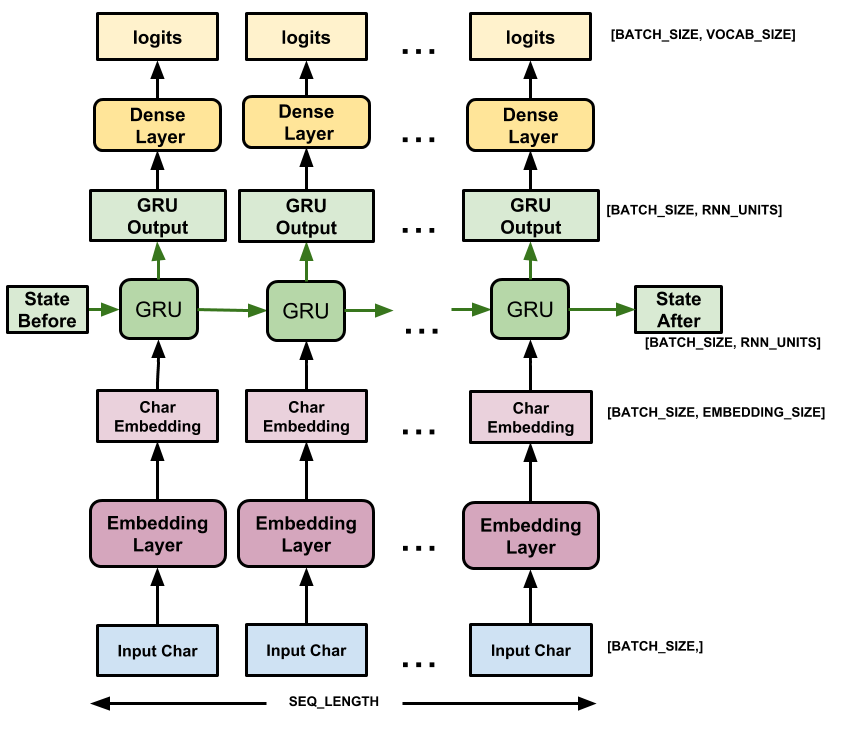

Image source: http://www.tensorflow.org

**EXERCISE 1** Complete the code of the `Model` class:

In [5]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.gru(emb, h)
        out = self.fc(out)
        return out, h
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden



Now we can instantiate the model as follows:

In [6]:
input_dim = len(dataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(dataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

model = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model)

Model(
  (embedding): Embedding(65, 300)
  (gru): GRU(300, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


As expected both inputs and outputs have the same shape, and the predicted characters are just random since the model is not trained yet.

## Train the model

Training a language model is essentially a classification problem. Given the previous RNN state, and the input character at this time step, predict the class of the next character.

**EXERCISE 2** which loss function do you think we shall use to train our model?

In [7]:
def train(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):
        state = model.init_hidden(batch_size)

        for batch, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_pred, state = model(x, state)
            loss = criterion(y_pred.transpose(1, 2), y)

            state = state.detach()

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
              print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
              losses.append(loss)
    return losses

Now train the model for 20 epochs and visualize the training loss curve.

{'epoch': 0, 'batch': 0, 'loss': 4.178797245025635}
{'epoch': 0, 'batch': 30, 'loss': 2.234736442565918}
{'epoch': 0, 'batch': 60, 'loss': 1.9522616863250732}
{'epoch': 0, 'batch': 90, 'loss': 1.7691837549209595}
{'epoch': 0, 'batch': 120, 'loss': 1.6870412826538086}
{'epoch': 0, 'batch': 150, 'loss': 1.625640869140625}
{'epoch': 1, 'batch': 0, 'loss': 1.5017962455749512}
{'epoch': 1, 'batch': 30, 'loss': 1.5229028463363647}
{'epoch': 1, 'batch': 60, 'loss': 1.508543848991394}
{'epoch': 1, 'batch': 90, 'loss': 1.476565957069397}
{'epoch': 1, 'batch': 120, 'loss': 1.43165922164917}
{'epoch': 1, 'batch': 150, 'loss': 1.460267186164856}
{'epoch': 2, 'batch': 0, 'loss': 1.3543646335601807}
{'epoch': 2, 'batch': 30, 'loss': 1.402320146560669}
{'epoch': 2, 'batch': 60, 'loss': 1.402004361152649}
{'epoch': 2, 'batch': 90, 'loss': 1.353227972984314}
{'epoch': 2, 'batch': 120, 'loss': 1.3769922256469727}
{'epoch': 2, 'batch': 150, 'loss': 1.3270400762557983}
{'epoch': 3, 'batch': 0, 'loss': 1.2

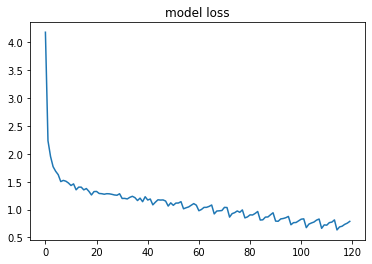

In [8]:
num_epochs = 20

losses = train(train_loader, model, batch_size, sequence_length, num_epochs)

# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

## Try the trained model

Let's try again to predict some characters given the input sentence 'ROMEO:'. Now the predicted characters should be much better.

In [9]:
with torch.no_grad():
  input_str = 'ROMEO:'

  state = model.init_hidden(batch_size=1)
  input = torch.tensor([[dataset.char_to_index[char] for char in input_str]]).to(device)
  output, state = model(input, state)

  logits = output[0].cpu().numpy()
  predicted_indexes = np.argmax(logits, axis=1)
  
  predicted_str = ''.join([dataset.index_to_char[idx] for idx in predicted_indexes])

  print(f'Input shape: {input.size()}')
  print(f'Output shape: {input.size()}')
  print(f'Input string: {input_str}')
  print(f'Output string: {predicted_str}')

Input shape: torch.Size([1, 6])
Output shape: torch.Size([1, 6])
Input string: ROMEO:
Output string: IKEO:



## Generate new text

In [10]:
with torch.no_grad():
  input_str = 'ROMEO:'

  state = model.init_hidden(batch_size=1)
  input = torch.tensor([[dataset.char_to_index[char] for char in input_str]]).to(device)
  output, state = model(input, state)

  logits = output[0].cpu().numpy()
  predicted_indexes = np.argmax(logits, axis=1)
  
  predicted_str = ''.join([dataset.index_to_char[idx] for idx in predicted_indexes])

  print(f'Input shape: {input.size()}')
  print(f'Output shape: {input.size()}')
  print(f'Input string: {input_str}')
  print(f'Output string: {predicted_str}')

Input shape: torch.Size([1, 6])
Output shape: torch.Size([1, 6])
Input string: ROMEO:
Output string: IKEO:



In [11]:
def predict(dataset, model, text, next_chars=500):
    model.eval()

    chars = [char for char in text]
    state = model.init_hidden(1)

    for i in range(0, next_chars):
        x = torch.tensor([[dataset.char_to_index[char] for char in chars[i:]]])
        x = x.to(device)
        y_pred, state = model(x, state)

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().cpu().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        chars.append(dataset.index_to_char[char_index])

    return chars

predicted = predict(dataset,model,'ROMEO:')
print(''.join(predicted))

ROMEO:
Goveable and grace!
But, following the rebuses
I would be done.

LORD RICHARD:
'Tis most unave to his sin quoth my fend out of this grace
The trembles her breathing than thou hast sour.

ROMEO:
Sir, being od senaboody when I show'd in,
To do throughly confine breast, take, from thence; but
like it.

ANTONIEL:
Happy the pity.

GLOUCESTER:
My gracious since
Beshrew my wife
Should her we prosperously repeal, if King Henry in the succeed to it.

LUCIO:
Come, my word,
How I peril.

DUKE VINCENTIO:
A


While some of the sentences are grammatical, most do not make sense. The model has not learned the meaning of words (we would need a much larger corpus for that, and probably a word level language model), but consider the following:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text. Now it does a pretty decent job on spelling.

* The structure of the output resembles a play, blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* The model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

# HOMEWORK

A) Build two new models: one using Simple RNN cells (torch.nn.RNN) instead of GRUs(torch.nn.RNN), and the other using LSTMs (torch.nn.LSTM). Train all three models (GRU, LSTM, SimpleRNN) for 30 epochs and compare the loss curves. You can optionally try different configurations: embedding dimension, hidden layers dimensions, number of layers, etc. 

In [12]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0., rnn_cell='RNN'):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn_cell = rnn_cell
        if self.rnn_cell == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True)
        elif self.rnn_cell == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        else:
            print('Using default Simple RNN cells')
            self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h, c=None):
        emb = self.embedding(x)
        if self.rnn_cell == 'LSTM': # in LSTM we have a cell state and a hidden state 
            out, (h, c) = self.rnn(emb, (h, c))
        else:                       # in GRU and RNN we only have one hidden state
            out, h = self.rnn(emb, h)
        out = self.fc(out)
        return out, h, c
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        weight = next(self.parameters()).data
        if self.rnn_cell == 'LSTM': # in LSTM we have a cell state and a hidden state
          return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device), weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        else:                       # in GRU and RNN we only have a hidden state
          return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device), None
        


In [13]:
def train(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):
        h_state, c_state = model.init_hidden(batch_size)

        for batch, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_pred, h_state, c_state = model(x, h_state, c_state) # in LSTM we have a cell state and a hidden state
       
            loss = criterion(y_pred.transpose(1, 2), y)

            h_state = h_state.detach()
            if c_state is not None:
                c_state = c_state.detach()
           
            loss.backward()
            optimizer.step()

            if batch%30 == 0:
              print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
              losses.append(loss)
    return losses

GRU
{'epoch': 0, 'batch': 0, 'loss': 4.174232006072998}
{'epoch': 0, 'batch': 30, 'loss': 2.2459092140197754}
{'epoch': 0, 'batch': 60, 'loss': 1.966139316558838}
{'epoch': 0, 'batch': 90, 'loss': 1.823917031288147}
{'epoch': 0, 'batch': 120, 'loss': 1.6882632970809937}
{'epoch': 0, 'batch': 150, 'loss': 1.6097298860549927}
{'epoch': 1, 'batch': 0, 'loss': 1.5726112127304077}
{'epoch': 1, 'batch': 30, 'loss': 1.5066043138504028}
{'epoch': 1, 'batch': 60, 'loss': 1.4998687505722046}
{'epoch': 1, 'batch': 90, 'loss': 1.4774539470672607}
{'epoch': 1, 'batch': 120, 'loss': 1.4371894598007202}
{'epoch': 1, 'batch': 150, 'loss': 1.46897554397583}
{'epoch': 2, 'batch': 0, 'loss': 1.3976565599441528}
{'epoch': 2, 'batch': 30, 'loss': 1.3575692176818848}
{'epoch': 2, 'batch': 60, 'loss': 1.3769357204437256}
{'epoch': 2, 'batch': 90, 'loss': 1.3917027711868286}
{'epoch': 2, 'batch': 120, 'loss': 1.345390796661377}
{'epoch': 2, 'batch': 150, 'loss': 1.397591233253479}
{'epoch': 3, 'batch': 0, 'lo

{'epoch': 25, 'batch': 0, 'loss': 0.5287293791770935}
{'epoch': 25, 'batch': 30, 'loss': 0.5797898769378662}
{'epoch': 25, 'batch': 60, 'loss': 0.5958377122879028}
{'epoch': 25, 'batch': 90, 'loss': 0.6439074873924255}
{'epoch': 25, 'batch': 120, 'loss': 0.6418114304542542}
{'epoch': 25, 'batch': 150, 'loss': 0.688494086265564}
{'epoch': 26, 'batch': 0, 'loss': 0.5236965417861938}
{'epoch': 26, 'batch': 30, 'loss': 0.5959047675132751}
{'epoch': 26, 'batch': 60, 'loss': 0.6115343570709229}
{'epoch': 26, 'batch': 90, 'loss': 0.6131587028503418}
{'epoch': 26, 'batch': 120, 'loss': 0.6457622051239014}
{'epoch': 26, 'batch': 150, 'loss': 0.6726528406143188}
{'epoch': 27, 'batch': 0, 'loss': 0.5045256614685059}
{'epoch': 27, 'batch': 30, 'loss': 0.5806896090507507}
{'epoch': 27, 'batch': 60, 'loss': 0.5925183296203613}
{'epoch': 27, 'batch': 90, 'loss': 0.6155484914779663}
{'epoch': 27, 'batch': 120, 'loss': 0.6376513838768005}
{'epoch': 27, 'batch': 150, 'loss': 0.6685278415679932}
{'epoch'

{'epoch': 20, 'batch': 0, 'loss': 0.38728997111320496}
{'epoch': 20, 'batch': 30, 'loss': 0.4536651372909546}
{'epoch': 20, 'batch': 60, 'loss': 0.4550236463546753}
{'epoch': 20, 'batch': 90, 'loss': 0.4798426330089569}
{'epoch': 20, 'batch': 120, 'loss': 0.510240375995636}
{'epoch': 20, 'batch': 150, 'loss': 0.49717581272125244}
{'epoch': 21, 'batch': 0, 'loss': 0.36284339427948}
{'epoch': 21, 'batch': 30, 'loss': 0.41367167234420776}
{'epoch': 21, 'batch': 60, 'loss': 0.42216870188713074}
{'epoch': 21, 'batch': 90, 'loss': 0.45127585530281067}
{'epoch': 21, 'batch': 120, 'loss': 0.47870826721191406}
{'epoch': 21, 'batch': 150, 'loss': 0.48886221647262573}
{'epoch': 22, 'batch': 0, 'loss': 0.32114890217781067}
{'epoch': 22, 'batch': 30, 'loss': 0.38085028529167175}
{'epoch': 22, 'batch': 60, 'loss': 0.4284290075302124}
{'epoch': 22, 'batch': 90, 'loss': 0.4277019500732422}
{'epoch': 22, 'batch': 120, 'loss': 0.44512614607810974}
{'epoch': 22, 'batch': 150, 'loss': 0.4489922821521759}


{'epoch': 14, 'batch': 150, 'loss': 1.2193505764007568}
{'epoch': 15, 'batch': 0, 'loss': 1.1352201700210571}
{'epoch': 15, 'batch': 30, 'loss': 1.1243586540222168}
{'epoch': 15, 'batch': 60, 'loss': 1.1746618747711182}
{'epoch': 15, 'batch': 90, 'loss': 1.190259575843811}
{'epoch': 15, 'batch': 120, 'loss': 1.1658803224563599}
{'epoch': 15, 'batch': 150, 'loss': 1.1634634733200073}
{'epoch': 16, 'batch': 0, 'loss': 1.1021965742111206}
{'epoch': 16, 'batch': 30, 'loss': 1.1170942783355713}
{'epoch': 16, 'batch': 60, 'loss': 1.1729108095169067}
{'epoch': 16, 'batch': 90, 'loss': 1.2082313299179077}
{'epoch': 16, 'batch': 120, 'loss': 1.1586133241653442}
{'epoch': 16, 'batch': 150, 'loss': 1.178544282913208}
{'epoch': 17, 'batch': 0, 'loss': 1.0865702629089355}
{'epoch': 17, 'batch': 30, 'loss': 1.132539987564087}
{'epoch': 17, 'batch': 60, 'loss': 1.1504851579666138}
{'epoch': 17, 'batch': 90, 'loss': 1.1268353462219238}
{'epoch': 17, 'batch': 120, 'loss': 1.157382607460022}
{'epoch': 1

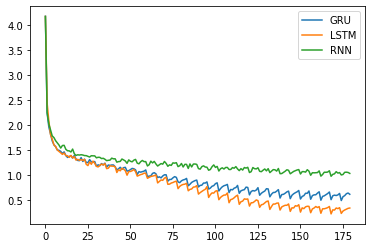

In [14]:
input_dim = len(dataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(dataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

num_epochs = 30

all_losses = {}
for cell_type in ['GRU','LSTM','RNN']:
    model = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob, rnn_cell=cell_type).to(device)
    print(cell_type)
    all_losses[cell_type] = train(train_loader, model, batch_size, sequence_length, num_epochs)

# Visualize the loss evolution during training
plt.figure()
for k in all_losses.keys():
  plt.plot(all_losses[k],label=k)
plt.legend()
plt.show()

B) Train your best model on a different dataset. Use the 'inaugural' corpus of the [NLTK](https://www.nltk.org/) library. Once trained generate some text with as we did for the model trained on the Shakespeare dataset. Compare the generated texts with both models using the smae "seed" (input) text. What differences do you appreciate? Why are they different?

The Natural Language Toolkit, or more commonly NLTK, is a suite of datasets, libraries and models for symbolic and statistical natural language processing (NLP). The Inaugural Address Corpus contains the US presidential inaugural addresses from 1789 to 2017. The following code loads the 'inaugural' corpus:

In [15]:
import nltk
nltk.download('inaugural')

inaugural = nltk.corpus.inaugural
text = inaugural.raw()

print(f'Length of text: {len(text)} characters')

[nltk_data] Downloading package inaugural to /home/lgomez/nltk_data...


Length of text: 793313 characters


[nltk_data]   Unzipping corpora/inaugural.zip.


In [16]:
class InauguralDataset():
    def __init__(self, sequence_length,):
        self.sequence_length = sequence_length
        # The whole sequence of characters in the text file (including chracters like the end of line character '\n', punctuation marks, etc.)
        self.chars = self.load_chars()
        # The list of unique characters (our vocabulary)
        self.uniq_chars = self.get_uniq_chars()

        # A dictionary with indexes as keys and characters as values
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        # A dictionary with characters as keys and indexes as values
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        # The whole sequence of character indexes
        # We want to vectorize our text using one-hot vectors at character level
        # But instead of using the one-hot vector we just keep the index of the 1 value
        self.chars_indexes = [self.char_to_index[w] for w in self.chars]

        # Split the sequence into chunks of `sequence_length` characters
        # `x` is the input to the model and `y` is the output of the model
        # `y` is the same seuqence as `x` but one character shifted to the right.
        self.x, self.y = self.get_data()

    def load_chars(self):
        inaugural = nltk.corpus.inaugural
        text = inaugural.raw()
        print(f'Length of text: {len(text)} characters')
        return text

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indexes)-self.sequence_length,self.sequence_length):
            x.append(np.array(self.chars_indexes[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indexes[index+1:index+self.sequence_length+1]))
        
        return  np.array(x), np.array(y)

In [17]:
# Create the dataset
sequence_length = 100
dataset_inaugural = InauguralDataset(sequence_length)

print(f'We have {dataset_inaugural.x.shape[0]} input sequence samples of length {dataset_inaugural.x.shape[1]} \
and {dataset_inaugural.y.shape[0]} label sequences of length {dataset_inaugural.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_data_inaugural = TensorDataset(torch.from_numpy(dataset_inaugural.x), torch.from_numpy(dataset_inaugural.y))
train_loader_inaugural = DataLoader(train_data_inaugural, shuffle=True, batch_size=batch_size, drop_last=True)

Length of text: 793313 characters
Unique characters (vocabulary size): 84
We have 7933 input sequence samples of length 100 and 7933 label sequences of length 100


In [ ]:
model_inaugural  = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob, rnn_cell='LSTM').to(device)
losses_inaugural = train(train_loader_inaugural, model_inaugural, batch_size, sequence_length, num_epochs)

In [ ]:
predicted = predict(dataset, model, 'What can')
print(''.join(predicted))

print (' ---------------------------------------- ')

predicted = predict(dataset_inaugural, model_inaugural, 'What can')
print(''.join(predicted))

We appreciate that the two models have learned the different language properties of the training data. Not only the vocabulary (the Sakespeare model tends to generate old English words), but also the topics (drama vs. politics), and the stucture of the text (play vs. paragraph).
